# Importuri

In [2]:
import pandas as pd
import sklearn
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import xgboost
from scipy.stats import entropy as en
import math
from sklearn.preprocessing import StandardScaler
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from tensorflow.keras.layers import Dense



# from sklearn.preprocessing import StandardScaler
# from imblearn.over_sampling import RandomOverSampler

# Customer Churn

## Dataset-ul

Pentru acest proiect am ales un dataset cu datele unei "companii" de telco. Datasetul este preluat de pe site-ul Kaggle: https://www.kaggle.com/datasets/blastchar/telco-customer-churn

clienții care au plecat în ultima lună - coloana se numește Churn
serviciile la care fiecare client s-a înscris - telefon, multi-line, internet, securitate online, backup online, protecție dispozitive, asistență tehnică și streaming TV/filme.
informații despre contul clientului - cât timp au fost clienți, contract, metodă de plată, facturare electronică, taxe lunare/totale
informații demografice despre clienți - gen, vârstă, parteneri și dependenți

## Preluarea datelor



In [3]:
#reading csv
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv", delimiter=",", na_values=" ")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



## Transformarea outputului din yes/no in int

In [4]:
df["Churn"] = (df["Churn"] == 'Yes').astype(int)

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [5]:
df.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,0
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,0
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,0
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,1
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.50,0


In [6]:

df.shape

(7043, 21)

In [7]:
categorical_features=[
    'gender', 
    'SeniorCitizen', 
    'Partner', 
    'Dependents',
    'PhoneService',
    'MultipleLines',
    'InternetService',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies',
    'Contract'
    'PaperlessBilling',
    'PaymentMethod'
]
numerical_features=['tenure','MonthlyCharges','TotalCharges']
target='Churn'

In [8]:
df[numerical_features].describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,72.000000,118.750000,8684.800000


Pentru ca modelul ml sa funcioneze trebuie ca anumite coloane sa fie convertite in numere(0 si 1 ex.gender 0 masulin si 1 feminin) iar altele sa fie impartie in 2(ex. internet service a fost impartit in 2 coloane, una cu dsl si una cu fibra optica ):

In [9]:
df.drop(['customerID'],axis = 1,inplace = True)

In [10]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [11]:
df.dropna(inplace=True)
df=pd.get_dummies(data=df,columns=['gender', 'Partner', 'Dependents',
                                    'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
                                    'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
                                    'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn'], drop_first=True)
df=df.astype(int)
df

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_1
0,0,1,29,29,0,1,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
1,0,34,56,1889,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,2,53,108,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,1
3,0,45,42,1840,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,0,2,70,151,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,24,84,1990,1,1,1,1,0,1,...,1,0,1,1,0,1,0,0,1,0
7039,0,72,103,7362,0,1,1,1,0,1,...,1,0,1,1,0,1,1,0,0,0
7040,0,11,29,346,0,1,1,0,1,0,...,0,0,0,0,0,1,0,1,0,0
7041,1,4,74,306,1,1,0,1,0,1,...,0,0,0,0,0,1,0,0,1,1


In [12]:
df.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_1
0,0,1,29,29,0,1,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
1,0,34,56,1889,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,2,53,108,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,1
3,0,45,42,1840,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,0,2,70,151,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,1


In [13]:
df.astype(int)
df

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_1
0,0,1,29,29,0,1,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
1,0,34,56,1889,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,2,53,108,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,1
3,0,45,42,1840,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,0,2,70,151,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,24,84,1990,1,1,1,1,0,1,...,1,0,1,1,0,1,0,0,1,0
7039,0,72,103,7362,0,1,1,1,0,1,...,1,0,1,1,0,1,1,0,0,0
7040,0,11,29,346,0,1,1,0,1,0,...,0,0,0,0,0,1,0,1,0,0
7041,1,4,74,306,1,1,0,1,0,1,...,0,0,0,0,0,1,0,0,1,1


In [14]:
(df.columns)

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges',
       'gender_Male', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'Churn_1'],
      dtype='object')

In [15]:
df = df[['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges',
           'gender_Male', 'Partner_Yes', 'Dependents_Yes',
           'PhoneService_Yes', 'MultipleLines_No phone service',
           'MultipleLines_Yes', 'InternetService_Fiber optic',
           'InternetService_No', 'OnlineSecurity_No internet service',
           'OnlineSecurity_Yes', 'OnlineBackup_No internet service',
           'OnlineBackup_Yes', 'DeviceProtection_No internet service',
           'DeviceProtection_Yes', 'TechSupport_No internet service',
           'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes',
           'StreamingMovies_No internet service', 'StreamingMovies_Yes',
           'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
           'PaymentMethod_Credit card (automatic)',
           'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check','Churn_1']]

# Correlation matrix

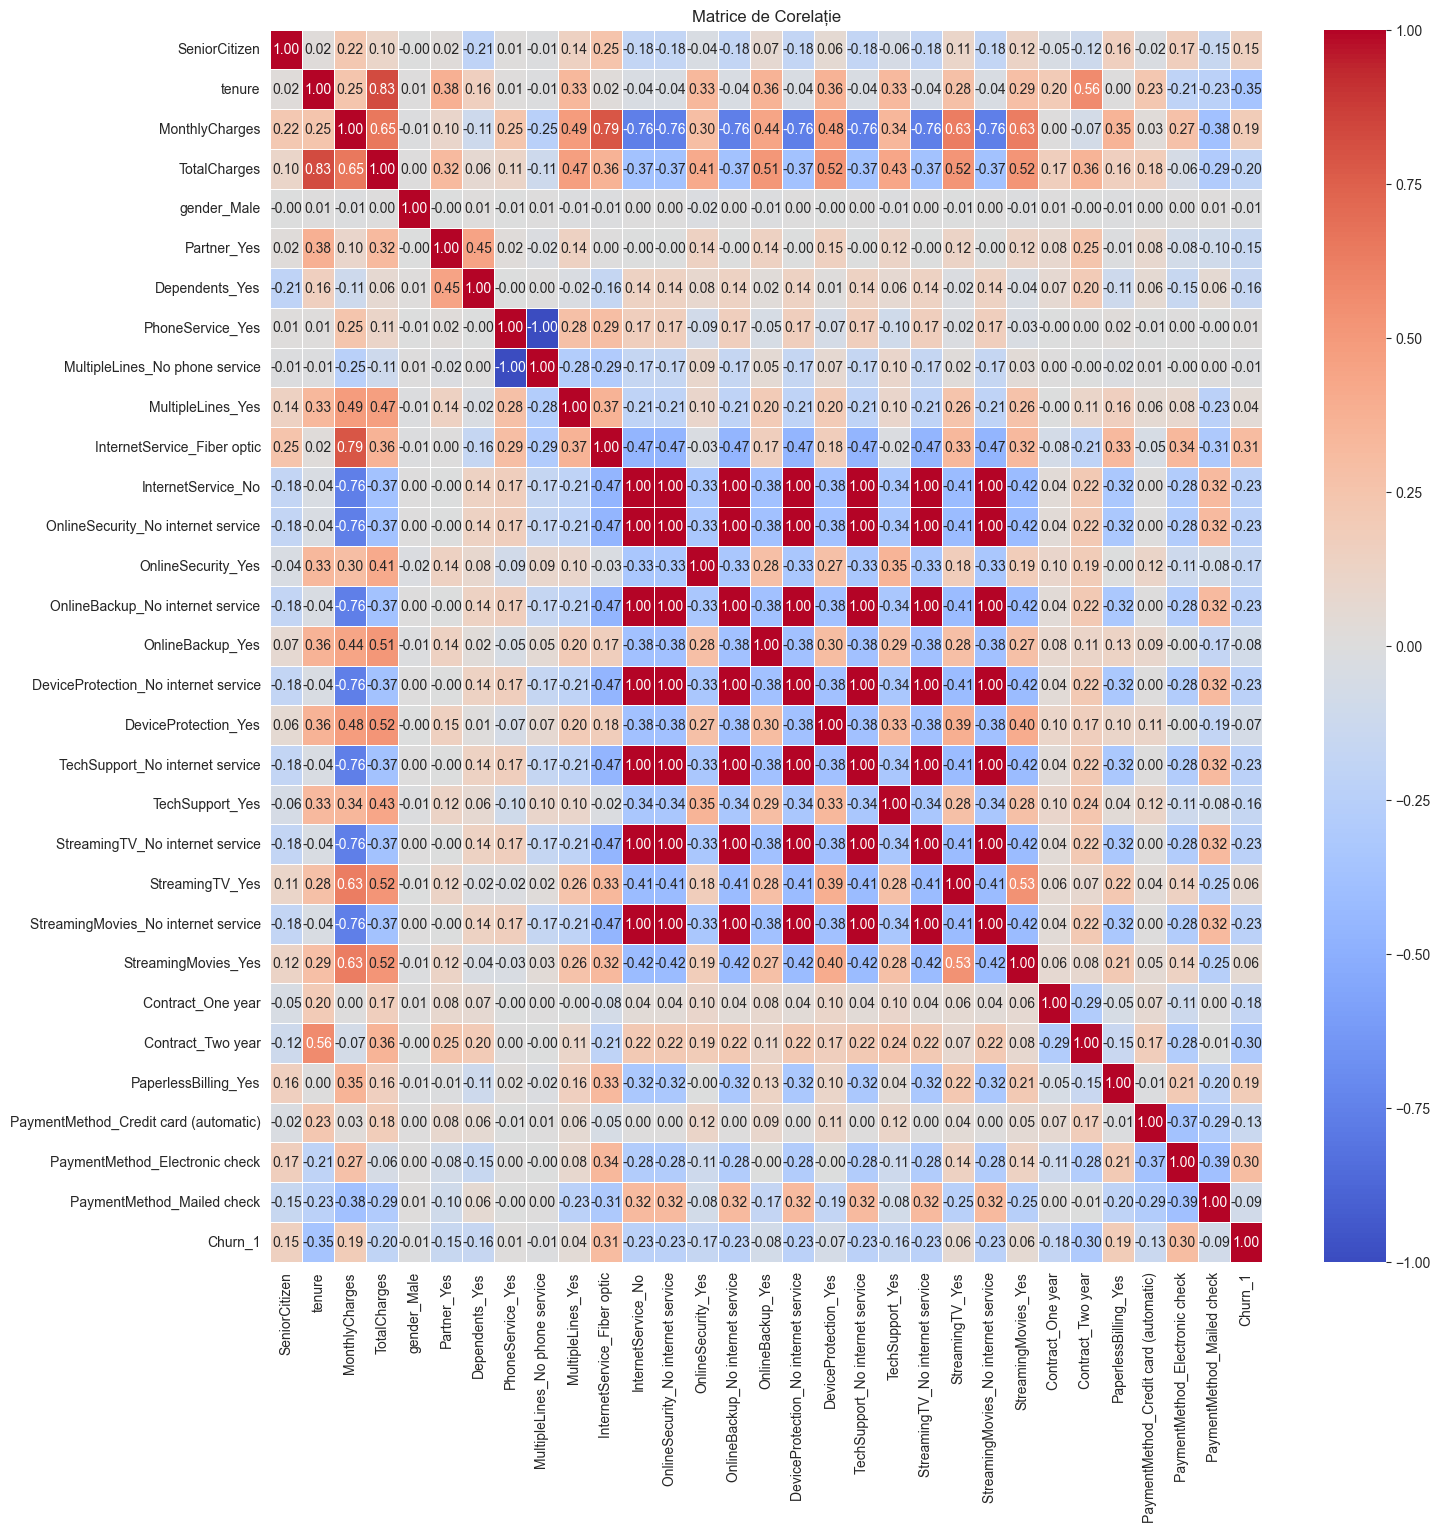

In [20]:
correlation_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(16, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matrice de Corelație')
plt.show()

In [21]:
scaler = StandardScaler()

In [22]:
scaler.fit(df.drop(['Churn_1'],axis = 1))
scaled_features = scaler.transform(df.drop('Churn_1',axis = 1))

# Histograma datelor

## Aici se poate observa distibutia datelor

In [23]:
# for label in df[:-1]:
#     plt.hist(df[df["Churn"]==1][label], color='b', label='Yes', alpha=0.7, density=True)
#     plt.hist(df[df["Churn"]==0][label], color='r', label='No', alpha=0.7, density=True)
#     plt.title(label)
#     plt.ylabel("probability")
#     plt.xlabel(label)
#     plt.legend()
#     plt.show()


In [24]:
df.isnull()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_1
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7039,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7040,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7041,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [25]:
df.isnull().sum()

SeniorCitizen                            0
tenure                                   0
MonthlyCharges                           0
TotalCharges                             0
gender_Male                              0
Partner_Yes                              0
Dependents_Yes                           0
PhoneService_Yes                         0
MultipleLines_No phone service           0
MultipleLines_Yes                        0
InternetService_Fiber optic              0
InternetService_No                       0
OnlineSecurity_No internet service       0
OnlineSecurity_Yes                       0
OnlineBackup_No internet service         0
OnlineBackup_Yes                         0
DeviceProtection_No internet service     0
DeviceProtection_Yes                     0
TechSupport_No internet service          0
TechSupport_Yes                          0
StreamingTV_No internet service          0
StreamingTV_Yes                          0
StreamingMovies_No internet service      0
StreamingMo

In [26]:
df.isnull().sum().sum()

0

## Stergerea datelor cu valori NaN

In [27]:
df.dropna(inplace=True)

In [28]:
df.isna().sum().sum()

0

In [29]:
df

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_1
0,0,1,29,29,0,1,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
1,0,34,56,1889,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,2,53,108,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,1
3,0,45,42,1840,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,0,2,70,151,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,24,84,1990,1,1,1,1,0,1,...,1,0,1,1,0,1,0,0,1,0
7039,0,72,103,7362,0,1,1,1,0,1,...,1,0,1,1,0,1,1,0,0,0
7040,0,11,29,346,0,1,1,0,1,0,...,0,0,0,0,0,1,0,1,0,0
7041,1,4,74,306,1,1,0,1,0,1,...,0,0,0,0,0,1,0,0,1,1



## Entropy

Entropia este o măsură a incertitudinii sau a dezordonării într-un set de date. Cu cât entropia este mai mare, cu atât incertitudinea este mai mare și, implicit, informația conținută în setul de date este mai mare.

In [30]:
en(df.value_counts())

8.816056474582329

In [31]:
def entropy(labels):
    unique_labels, label_counts = np.unique(labels, return_counts=True)
    probabilities = label_counts / len(labels)
    entropy_value = -np.sum(probabilities * np.log2(probabilities))
    return entropy_value

for label in df[:-1]:
    print(label, entropy(df[label]))



SeniorCitizen 0.6400214027212845
tenure 5.914257891990094
MonthlyCharges 5.979715162433632
TotalCharges 11.45176953142003
gender_Male 0.9999364550464405
Partner_Yes 0.9991170306066908
Dependents_Yes 0.8794404586827863
PhoneService_Yes 0.45844925718753027
MultipleLines_No phone service 0.45844925718753027
MultipleLines_Yes 0.9823408405367391
InternetService_Fiber optic 0.9896822991083725
InternetService_No 0.7530837185380153
OnlineSecurity_No internet service 0.7530837185380153
OnlineSecurity_Yes 0.8642191874399958
OnlineBackup_No internet service 0.7530837185380153
OnlineBackup_Yes 0.9293863281716901
DeviceProtection_No internet service 0.7530837185380153
DeviceProtection_Yes 0.9284615332282073
TechSupport_No internet service 0.7530837185380153
TechSupport_Yes 0.8688534723572245
StreamingTV_No internet service 0.7530837185380153
StreamingTV_Yes 0.9610806778229317
StreamingMovies_No internet service 0.7530837185380153
StreamingMovies_Yes 0.9637379297728217
Contract_One year 0.7401977722

## Gini Index
Indicele Gini este o măsură a inegalității sau impurității într-un set de date și este folosit în algoritmi de clasificare pentru a determina cea mai bună caracteristică de separare a datelor. Cu cât indicele Gini este mai mic, cu atât este mai bine separat setul de date.

In [32]:
def gini_index(labels):
    unique_labels, label_counts = np.unique(labels, return_counts=True)
    probabilities = label_counts / len(labels)
    gini_value =  np.sum(probabilities**2)
    return gini_value

for label in df[:-1]:
    print(label, gini_index(df[label]))

SeniorCitizen 0.7279469054839183
tenure 0.02245455845599703
MonthlyCharges 0.024585035288057458
TotalCharges 0.000757426476203049
gender_Male 0.5000440453587113
Partner_Yes 0.5006119028759799
Dependents_Yes 0.5812104602913902
PhoneService_Yes 0.8253004953141239
MultipleLines_No phone service 0.8253004953141239
MultipleLines_Yes 0.512190372048597
InternetService_Fiber optic 0.5071346200887605
InternetService_No 0.6611362845098823
OnlineSecurity_No internet service 0.6611362845098823
OnlineSecurity_Yes 0.5911241847766298
OnlineBackup_No internet service 0.6611362845098823
OnlineBackup_Yes 0.548141738854138
DeviceProtection_No internet service 0.6611362845098823
DeviceProtection_Yes 0.5487614881943879
TechSupport_No internet service 0.6611362845098823
TechSupport_Yes 0.5881140141411083
StreamingTV_No internet service 0.6611362845098823
StreamingTV_Yes 0.5267333486703398
StreamingMovies_No internet service 0.6611362845098823
StreamingMovies_Yes 0.5249236466224287
Contract_One year 0.668979

# Models

Last preparation

In [33]:

X = scaled_features
Y = df['Churn_1']
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.3,random_state=42)




## Logistic Regression

training

In [34]:
logmodel = LogisticRegression()
logmodel.fit(X_train,Y_train)

LogisticRegression()

In [35]:
predLR = logmodel.predict(X_test)

In [36]:
Y_test

2481    0
6784    0
6125    1
3052    0
4099    0
       ..
2763    0
6747    0
1700    0
1099    0
4720    0
Name: Churn_1, Length: 2110, dtype: int32

In [37]:
accuracy = accuracy_score(Y_test, predLR)
precision = precision_score(Y_test, predLR)
recall = recall_score(Y_test, predLR)
f1 = f1_score(Y_test, predLR)
cm = confusion_matrix(Y_test, predLR)

print("Evaluation Metrics:")
print("Accuracy:", Aaccuracy)
print("Precision:", precision)
print("Confusion Matrix:\n", cm)

Evaluation Metrics:
Accuracy: 0.79478672985782
Precision: 0.6361702127659574
Confusion Matrix:
 [[1378  171]
 [ 262  299]]


## confusion matrix
[true positive] [false positive]
[false negative] [true negative]

# Random forest

In [48]:
modelrf = RandomForestClassifier(n_estimators=100,criterion='entropy',max_depth=10, min_samples_split=10, random_state=100,min_samples_leaf=11,max_features='log2',oob_score=callable(int))
modelrf.fit(X_train, Y_train)

y_pred_rf=modelrf.predict(X_test)

accuracy = accuracy_score(Y_test, y_pred_rf)
precision = precision_score(Y_test, y_pred_rf)
recall = recall_score(Y_test, y_pred_rf)
f1 = f1_score(Y_test, y_pred_rf)
cm = confusion_matrix(Y_test, y_pred_rf)

print("Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Confusion Matrix:\n", cm)


Evaluation Metrics:
Accuracy: 0.7928909952606635
Precision: 0.6565656565656566
Confusion Matrix:
 [[1413  136]
 [ 301  260]]


# XGBoost

In [40]:
model2 = XGBClassifier()
model2.fit(X_train, Y_train)
Y_pred = model2.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
cm = confusion_matrix(Y_test, Y_pred)

print("Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:\n", cm)

Evaluation Metrics:
Accuracy: 0.7729857819905214
Precision: 0.5810276679841897
Recall: 0.5240641711229946
F1-score: 0.5510777881911902
Confusion Matrix:
 [[1337  212]
 [ 267  294]]


## K-nn

In [41]:
knn = KNeighborsClassifier(n_neighbors=8,leaf_size=100)  
knn.fit(X_train, Y_train)
y_pred = knn.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
cm = confusion_matrix(Y_test, Y_pred)
print("Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", cm)

Evaluation Metrics:
Accuracy: 0.7729857819905214
Precision: 0.5810276679841897
Recall: 0.5240641711229946
Confusion Matrix:
 [[1337  212]
 [ 267  294]]


## Testarea modeului cu date introduse manual-nefunctional

In [42]:
test_data = [
    [0,45,25,1216,0,1,1,1,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,0,0],
    [0,1,79,79,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0],
    [0,11,50,565,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0],
    [0,7,75,496,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0],
    [0,42,103,4327,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0],
    [0,49,20,973,0,1,0,1,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,0],
    [0,9,99,918,1,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,1,0,0],
    [0,35,62,2215,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0],
    [0,48,20,1057,0,1,1,1,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0],
    [0,46,19,927,0,1,1,1,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1],
    [0,29,33,1009,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1],
    [0,30,82,2570,1,1,1,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0],
    [1,1,74,74,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0],
    [0,66,84,5714,1,1,1,1,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,0,0,1],
    [0,65,111,7107,0,0,0,1,0,1,1,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,1,1,0,0],
    [0,72,100,7459,1,0,0,1,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,1,0,0,0],
    [0,12,78,927,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0],
    [0,71,66,4748,1,1,1,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,1,1,0,0],
    [0,5,21,113,1,0,0,1,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1],
    [0,52,21,1107,1,0,0,1,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0],
    [1,25,98,2514,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,1,0],



]
Churn1=[ 0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1 ]
         


columns = ['SeniorCitizen','tenure','MonthlyCharges','TotalCharges','gender_Male','Partner_Yes','Dependents_Yes','PhoneService_Yes','MultipleLines_No phone service','MultipleLines_Yes','InternetService_Fiber optic','InternetService_No','OnlineSecurity_No internet service','OnlineSecurity_Yes','OnlineBackup_No internet service','OnlineBackup_Yes','DeviceProtection_No internet service','DeviceProtection_Yes','TechSupport_No internet service', 'TechSupport_Yes','StreamingTV_No internet service','StreamingTV_Yes','StreamingMovies_No internet service','StreamingMovies_Yes','Contract_One year','Contract_Two year','PaperlessBilling_Yes','PaymentMethod_Credit card (automatic)','PaymentMethod_Electronic check','PaymentMethod_Mailed check' ]

df_test = pd.DataFrame(test_data)
X_test1 = df_test
y_test1 = Churn1

In [43]:
#df_test

In [44]:
predictions = logmodel.predict(df_test)

In [45]:
y_test1


[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1]

In [46]:
accuracy = accuracy_score(Churn1, predictions)

precision = precision_score(Churn1, predictions)
recall = recall_score(Churn1, predictions)
cm = confusion_matrix(Churn1, predictions)
print(predictions)
print("Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", cm)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Evaluation Metrics:
Accuracy: 0.23809523809523808
Precision: 0.23809523809523808
Recall: 1.0
Confusion Matrix:
 [[ 0 16]
 [ 0  5]]
